In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [4]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [5]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [6]:
# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
adam = Adam(lr=0.0002, beta_1=0.5)

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
Generator_input = tf.keras.Input(shape=(NOISE_DIM,) )
x = Dense(256)(Generator_input)
x = LeakyReLU(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU(0.2)(x)
x = Dense(1024)(x)
x = LeakyReLU(0.2)(x)
Generator_output = Dense(28*28, activation='tanh')(x)

Generator = tf.keras.Model(Generator_input, Generator_output, name="Generator")
Generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0 

In [8]:
Discriminator_input = tf.keras.Input(shape=(784,))
x = Dense(1024, kernel_initializer=RandomNormal(stddev=0.02))(Discriminator_input)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)
x = LeakyReLU(0.2)(x)
x = Dense(256)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
Discriminator_output = Dense(1, activation='sigmoid')(x)

Discriminator = tf.keras.Model(Discriminator_input, Discriminator_output)
Discriminator.compile(loss='binary_crossentropy', optimizer=adam)
Discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328

In [9]:
Discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
x = Generator(inputs=gan_input)
output = Discriminator(x)

In [10]:
GAN = Model(gan_input, output)
GAN.compile(loss='binary_crossentropy', optimizer=adam)

In [11]:
GAN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 Generator (Functional)      (None, 784)               1463312   
                                                                 
 model (Functional)          (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [12]:
GAN.compile(loss='binary_crossentropy', optimizer=adam)

In [13]:
def visualize_training(epoch, d_losses, g_losses, Generator):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    Generated_images = Generator.predict(noise)
    Generated_images = Generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(Generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(Generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

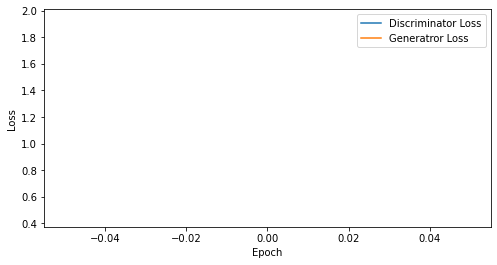

epoch: 1, Discriminator Loss: 0.44798049330711365, Generator Loss: 1.9345734119415283
1/1 [==============================] - 0s 123ms/step


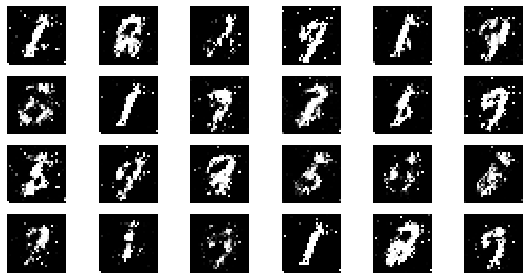

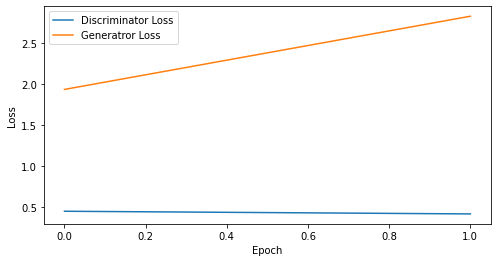

epoch: 2, Discriminator Loss: 0.43172813951969147, Generator Loss: 2.3810503482818604
1/1 [==============================] - 0s 44ms/step


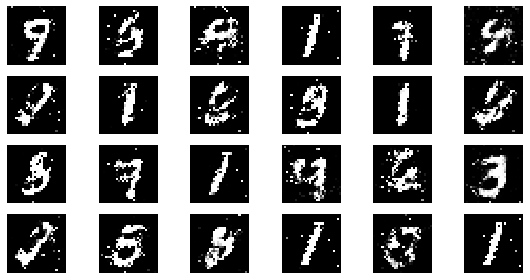

KeyboardInterrupt: 

In [15]:
EPOCHS = 10
BATCH_SIZE = 32

d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        Generated_images = Generator.predict(input_noise, verbose=0)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, Generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        Discriminator.trainable = True
        d_loss = Discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        Discriminator.trainable = False
        g_loss = GAN.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    
    visualize_training(epoch, d_losses, g_losses, Generator)

In [16]:
input_noise.shape

(32, 10)